# Quantify Flakes

One of the key perfomance indicators that we would like to create greater visbility into and track over time is overall number and percent of flakes that occur. Individual test runs are flagged a "flake" if they are run mulitple times with a mix of passes and failes without any changes to the code being tested. Although they occur for individual test runs, there are a number of aggregate views that developers may want to look at to assess the overall health of thier project or testing platform. For Example:

* percent flakes on platform each day
* percent flakes by tab each week
* percent flakes by grid each month
* percent flakes by test overall (this can also be seen as a severity level = overall flake rate of test)

In order to provide maxium flexibility for the end-user of this work, instead of creating a number of dataframes to answer each of these specifc questions, we will define a long and narrow data structure (a list of tuples saved as a csv for now) that contains only 5 columns ("timestamp", "tab","grid","test","flake"). This allows superset (or pandas) to perform the last filter and/or aggreagtion of interest to an end user. Which is to say, there may appear to be a lot of repetion within the final dataset, but each row should be unique, and it should provide the simpelest useability for an end-user.    


In [1]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


from ipynb.fs.defs.metric_template import testgrid_labelwise_encoding
from ipynb.fs.defs.metric_template import CephCommunication
from ipynb.fs.defs.metric_template import save_to_disk, read_from_disk
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

True

In [2]:
## Specify variables
METRIC_NAME = "number_of_flakes"
# Specify the path for input grid data,
INPUT_DATA_PATH = "../../../../data/raw/testgrid_810.json.gz"

# Specify the path for output metric data
OUTPUT_DATA_PATH = f"../../../../data/processed/metrics/{METRIC_NAME}"

# Specify whether or not we are running this as a notebook or part of an automation pipeline.
AUTOMATION = os.getenv("IN_AUTOMATION")

## CEPH Bucket variables
## Create a .env file on your local with the correct configs,
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")
s3_input_data_path = "raw_data"
metric_path = f"metrics/{METRIC_NAME}"

In [3]:
## Set filename
timestamp = datetime.datetime.today()
filename = f"testgrid_{timestamp.day}{timestamp.month}.json"

In [4]:
## Connect to Ceph
cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)

## Read testgrid data from ceph
s3_object = cc.s3_resource.Object(s3_bucket, f"{s3_input_data_path}/{filename}")
file_content = s3_object.get()["Body"].read().decode("utf-8")
testgrid_data = json.loads(file_content)

## Calculation
- In this section, we calculate the metric values from the data.

In [5]:
unrolled_list = testgrid_labelwise_encoding(testgrid_data, 13)

In [6]:
# Convert to dataframe
df = pd.DataFrame(
    unrolled_list,
    columns=["timestamp", "tab", "grid", "test", "test_duration", "flake"],
)
df.head()

,timestamp,tab,grid,test,test_duration,flake
0,2021-04-05 00:01:25,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,104.233333,False
1,2021-04-03 05:27:36,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,87.050000,False
2,2021-04-02 04:53:26,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,103.250000,False
3,2021-04-02 03:35:48,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,105.516667,False
4,2021-04-01 06:25:22,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,118.850000,False


### Flake Severity Metric 
Some tests would be flaky for a lot of builds and thus have a high flake rate or severity. This metric can be leveraged to help prioritize the work needed to resolve the flake issues.

In [7]:
df_flake_severity = df[["test", "flake"]]
df_flake_severity.describe()

,test,flake
count,1715915,1715915
unique,1915,2
top,Pod,False
freq,1877,1712252


In [8]:
## The following metric implements flake severity
## or flake rate by tests
## Moving forward, this will be aggregated in Superset
## For the sake of completeness, it is implmented here
flake_severity = df.groupby("test").flake.mean().reset_index()
flake_severity.rename(columns={"flake": "flake_severity"}, inplace=True)
flake_severity

,test,flake_severity
0,Cluster upgrade.Application behind service loa...,0.067285
1,Cluster upgrade.Check if critical alerts are f...,0.000000
2,Cluster upgrade.Cluster frontend ingress remai...,0.047564
3,Cluster upgrade.Kubernetes APIs remain available,0.042923
4,Cluster upgrade.OpenShift APIs remain available,0.047564
...,...,...
1910,operator.Tag the image ovirt-installer into th...,0.000000
1911,operator.Tag the image ovn-kubernetes into the...,0.000000
1912,operator.Tag the image sdn into the image stre...,0.000000
1913,operator.Tag the image tests into the image st...,0.000000


## Visualization 
- Here, we provide a quick visualization of the computed metric.

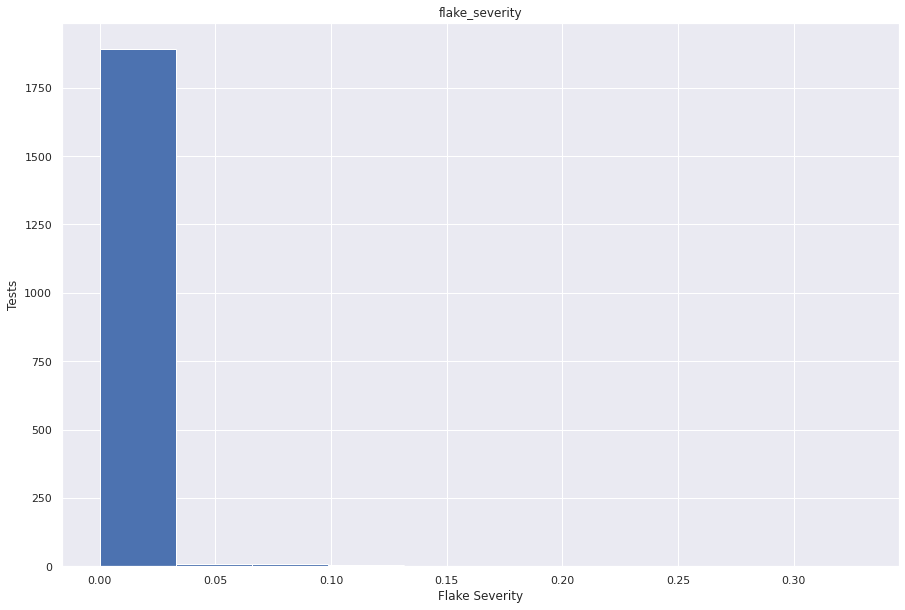

In [9]:
sns.set(rc={"figure.figsize": (15, 10)})
flake_severity.hist()
plt.ylabel("Tests")
plt.xlabel("Flake Severity")
plt.show()

From the above graph we can conclude that most of the tests have very low(~0) flake severity. One might look at this graph and assume that almost all of the tests have flake severity as 0. So, to get more clarity we have plotted another graph and here we've gone from about 8,000 tests to investigate for probable flakiness to less than 100. 

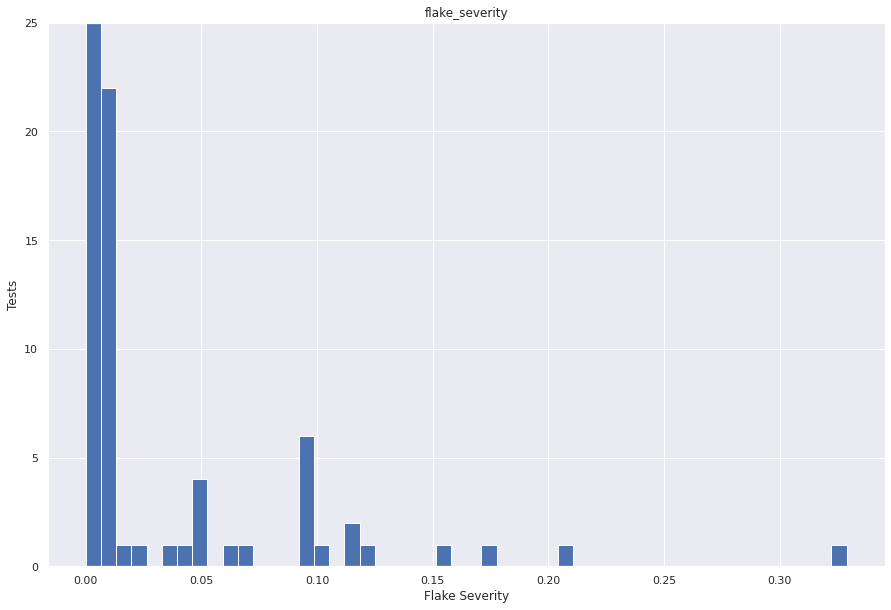

In [10]:
sns.set(rc={"figure.figsize": (15, 10)})
flake_severity.hist(bins=50)
plt.ylabel("Tests")
plt.xlabel("Flake Severity")
plt.ylim((0, 25))
plt.show()

From the above graph we can see that there are other values of flake severity for some tests. However it is a small bunch of tests that show a different set of flake severity. Let's see some tests that have a high flake severity score.

The top 5 tests with the highest flake score :

In [11]:
flake_severity.nlargest(5, "flake_severity")

,test,flake_severity
552,openshift-tests.[sig-arch] Monitor cluster whi...,0.328932
962,openshift-tests.[sig-node] pods should never t...,0.208200
61,Cluster upgrade.[sig-network-edge] Application...,0.173290
62,Cluster upgrade.[sig-network-edge] Cluster fro...,0.157003
53,Cluster upgrade.[sig-arch] Check if alerts are...,0.122349


In [12]:
# Overall flake percentage
df.flake.sum() / df.flake.count()

0.0021347211254636738

### Save results to Ceph or locally
* Use the following helper function to save the data frame in a parquet format on the Ceph bucket if we are running in automation, and locally if not.

In [13]:
filename = f"{METRIC_NAME}-{timestamp.year}-{timestamp.month}-{timestamp.day}.parquet"

if AUTOMATION == "True":
    cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
    cc.upload_to_ceph(df, metric_path, filename)
else:
    save_to_disk(df, OUTPUT_DATA_PATH, filename)

In [14]:
## Sanity check to see if the dataset is the same
if AUTOMATION == "True":
    sanity_check = cc.read_from_ceph(metric_path, filename)
else:
    sanity_check = read_from_disk(OUTPUT_DATA_PATH, filename)

sanity_check

,timestamp,tab,grid,test,test_duration,flake
0,2021-04-05 00:01:25,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,104.233333,False
1,2021-04-03 05:27:36,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,87.050000,False
2,2021-04-02 04:53:26,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,103.250000,False
3,2021-04-02 03:35:48,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,105.516667,False
4,2021-04-01 06:25:22,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,118.850000,False
...,...,...,...,...,...,...
1715910,2021-03-23 12:42:44,"""redhat-openshift-informing""",release-openshift-origin-installer-launch-vsphere,operator.Run multi-stage test launch - launch-...,NaN,False
1715911,2021-03-23 02:04:42,"""redhat-openshift-informing""",release-openshift-origin-installer-launch-vsphere,operator.Run multi-stage test launch - launch-...,NaN,False
1715912,2021-03-22 21:05:51,"""redhat-openshift-informing""",release-openshift-origin-installer-launch-vsphere,operator.Run multi-stage test launch - launch-...,NaN,False
1715913,2021-03-22 12:42:56,"""redhat-openshift-informing""",release-openshift-origin-installer-launch-vsphere,operator.Run multi-stage test launch - launch-...,NaN,False


### Conclusion
This notebook computed number of flakes and the flake severity metric. The dataframe saved on ceph can be used to generate aggregated views and visualizations.